<h1 align="center">Volume 4: River Crossing.</h1>

    NAME Daniel Smith
    Section #2
    DATE 24 February 2022

In [50]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.interpolate import barycentric_interpolate
from scipy.optimize import root
from matplotlib import pyplot as plt

# Problem 1
Assume that the current is given by $c(x) = −
\frac{7}{10} (x^2 − 1)$. (This function assumes, for example, that the current is faster near the center of the river.) Write a Python
function that accepts as arguments a function $y$, its derivative $y'$, and an $x$-value, and returns $L(x, y(x), y'(x))$ (where $T[y]=\int^1_{-1} L(x,y(x),y'(x))dx$ Use that function to defune a second
function that numerically computes $T[y]$ for a given path $y(x)$.

In [51]:
c = lambda x: (-7/10)*(x**2 - 1)
alpha = lambda x: (1 - c(x)**2)**(-1/2)

def L(x, y, yp):
    """
    Function for L(x, y, y')
    """
    return alpha(x)*np.sqrt(1 + (alpha(x)*yp(x))**2) - alpha(x)**2*c(x)*yp(x)

def T(y, yp):
    """
    Evaluate the functional T[y]
    """
    return quad(L, -1, 1, args = (y, yp))[0]

# Problem 2

Let y(x) be the straight-line path between A = (−1, 0) and B = (1, 5). Numerically calculate T[y] to get an upper bound on the minimum time required to cross from A to
B. Using (18.2), find a lower bound on the minimum time required to cross.

In [52]:
y = lambda x: 5/2*x + 5/2 # Initialize y and yp for upper bound calculation 
yp = lambda x: 5/2
upper_bound = T(y, yp) # Save upper bound 

func = lambda x: 1/np.cos(x) # Initialize function to minimize for lower bound 
min_val = func(minimize(func, 1).x[0])
lower_bound = quad(lambda x: min_val, -1, 1)[0] # Save lower bound 

print(f"Upper Bound: {upper_bound} \nLower Bound: {lower_bound}")

Upper Bound: 3.877082049138412 
Lower Bound: 2.000000000000831


# Problem 3

Numerically solve the Euler-Lagrange equation (18.4), using c(x) = −
7
10 (x
2 − 1)
and α = (1 − c
2
)
−1/2
, and y(−1) = 0, y(1) = 5.
Hint: Since this boundary value problem is defined over the doimain [−1, 1], it is easy to
solve using the pseudospectral method. Begin by replacing each d
dx with the pseudospectral
differentiation matrix D. Then impose the boundary conditions and solve.

/Users/danielsmith/venv/lib/python3.9/site-packages/scipy/interpolate/polyint.py:547: RuntimeWarning: divide by zero encountered in reciprocal
  self.wi **= -1


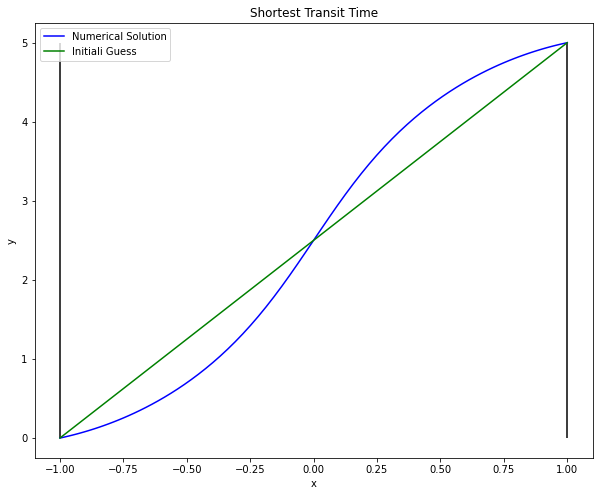

In [127]:
y = lambda x: 5/2*x + 5/2
#y = np.vectorize(y)

def cheb(N):
    """
    Get D and the chebyshev points 
    """
    x = np.cos((np.pi/N)*np.linspace(0,N,N+1))
    x.shape = (N+1,1)
    lin = np.linspace(0,N,N+1)
    lin.shape = (N+1,1)
    
    c = np.ones((N+1,1))
    c[0], c[-1] = 2., 2.
    c = c*(-1.)**lin
    X = x*np.ones(N+1) # broadcast along 2nd dimension (columns)
    
    dX = X - X.T
    
    D = (c*(1./c).T)/(dX + np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    x.shape = (N+1,)
    # Here we return the differentiation matrix and the Chebyshev points,
    # numbered from x_0 = 1 to x_N = -1
    return D, x

D, x = cheb(100) # Get D and x

a_, c_ = alpha(x), c(x)
def F(U):
    # Find the root of the function 
    out = D@(a_**3*(D@U)*(1 + (a_**2*(D@U)**2))**(-1/2)-a_**2*c_)
    out[0] = U[0] - 5
    out[-1] = U[-1]
    return out

dom = np.linspace(-1, 1, 101) # Initialize domain 
guess = y(x) # Initial guess
sol = root(F, guess).x # Solve
bary = barycentric_interpolate(x, sol, dom) # Interpolate 

# Generate plots 
plt.figure(figsize = (10, 8))
plt.plot(x, sol, color = "blue", label = "Numerical Solution")
plt.plot(dom, y(dom), color = "green", label = "Initiali Guess")
plt.vlines(-1, 0, 5, color = "black")
plt.vlines(1, 0, 5, color = "black")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Shortest Transit Time")
plt.legend()
plt.show()

# Problem 4

Plot the angle at which the boat should be pointed at each $x$-coordinate. (Hint: use Equation 1.1; see Figure 1.3. Note that the angle the boat should be steered is NOT described by the tangent vector to the trjaectory)

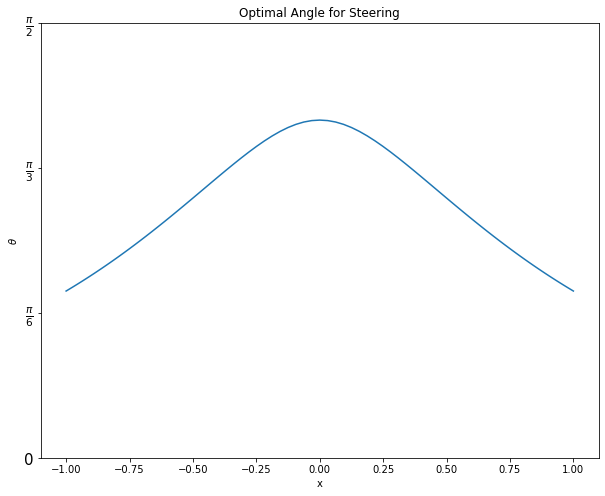

In [162]:
yp = D@sol # Get y'

def func(theta):
    """
    Function to optimize for theta 
    """
    return c_/np.cos(theta) + np.tan(theta) - yp

sol0 = root(func, np.ones_like(yp)*np.pi/4).x # Solve for theta 

# Radian labels and stuff
y_pi   = sol0/np.pi
unit = 1/6
y_tick = np.arange(-0.5, 0.5+unit, unit)
y_label = [r"$-\frac{\pi}{2}$", r"$-\frac{\pi}{3}$", 
           r"$-\frac{\pi}{6}$", r"$0$", r"$\frac{\pi}{6}$",
           r"$\frac{\pi}{3}$", r"$\frac{\pi}{2}$"]

# Generate plot 
plt.figure(figsize = (10, 8))
plt.yticks(y_tick*np.pi, labels = y_label, fontsize = 15)
plt.ylim(0, np.pi/2)
plt.plot(x, sol0)
plt.xlabel("x")
plt.ylabel(r"$\theta$")
plt.title("Optimal Angle for Steering")
plt.show()